### 集成学习 Ensemble_learning
1. bagging :训练多个分类器取平均值（并行）

- 随机森林（random_forest）
    可解释性强,自动特征选择

随机： 数据采样随机，特征选择随机

森林：多个决策树并行放在一起
  
---

2. boosting: 从弱学习器开始加强，通过加权来优化性能（串行）

- AdaBoost（Adaptive Boosting）：
  - **核心思想**：通过迭代调整样本权重，让后续模型更关注被前序模型错误分类的样本。
  - **基学习器**：通常使用极简单的模型（如单层决策树，即“树桩”）。
  - **损失函数**：基于指数损失函数（Exponential Loss），直接优化分类错误率。

- XGBoost（Extreme Gradient Boosting）：
  - **核心思想**：基于梯度提升框架，通过优化损失函数和模型复杂度，逐步提升预测性能。
  - **基学习器**：使用更复杂的决策树（可自定义深度和节点分裂条件）。
  - **损失函数**：支持自定义损失函数（如平方误差、交叉熵等），并引入**正则化项**（L1/L2正则）控制过拟合。



| **特性**              | **AdaBoost**                          | **XGBoost**                          |
|-----------------------|---------------------------------------|---------------------------------------|
| **基学习器**          | 简单模型（如树桩）                    | 复杂模型（深度树）                    |
| **并行化**            | 不支持                                | 支持（特征/数据分块）                 |
| **正则化**            | 无                                    | 支持（L1/L2正则）                     |
| **缺失值处理**        | 需手动处理                            | 自动处理                              |
| **训练速度**          | 较快（简单模型）                      | 较慢（但优化后效率高）                |
| **过拟合风险**        | 高（复杂数据易过拟合）                | 低（正则化控制）                      |
| **适用场景**          | 小数据、简单分类                      | 大数据、复杂任务                      |

---

3. stacking
    
    聚合多个模型，将前一阶段的输出，作为下一阶段的输入再次训练

In [61]:
from sklearn.model_selection import  train_test_split
from sklearn.datasets import make_moons
# 生成两个交错排列的“月牙形”（或“半月形”）数据点
X,y = make_moons(n_samples = 500 , noise=0.3 , random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

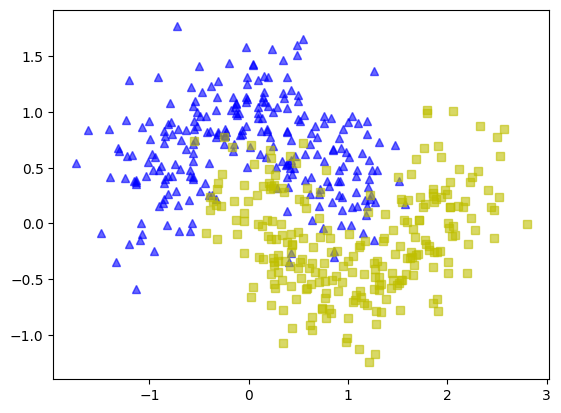

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# alpha 透明度
plt.plot(X[:,0][y==0],X[:,1][y==0],'b^',alpha = 0.6 )
plt.plot(X[:,0][y==1],X[:,1][y==1],'ys',alpha = 0.6 )
plt.show()


#### 投票策略 
- 硬投票：直接用类别值，少数服从多数
- 软投票：各自分类器的概率值进行加权


如果为基模型分配不同的权重（例如模型A权重为2，模型B和模型C权重为1），计算过程如下：

| 基模型   | 权重 | 类别0的概率 | 类别1的概率 |
|----------|------|-------------|-------------|
| **模型A** | 2    | 0.7         | 0.3         |
| **模型B** | 1    | 0.6         | 0.4         |
| **模型C** | 1    | 0.4         | 0.6         |

  **计算加权平均概率**
- **类别0的加权平均概率** = (2×0.7 + 1×0.6 + 1×0.4) / (2+1+1) = (1.4 + 0.6 + 0.4) / 4 = 2.4 / 4 = **0.6**
- **类别1的加权平均概率** = (2×0.3 + 1×0.4 + 1×0.6) / 4 = (0.6 + 0.4 + 0.6) / 4 = 1.6 / 4 = **0.4**

 **最终预测结果**
- 类别0的加权平均概率（0.6）> 类别1的加权平均概率（0.4）
- 最终预测仍为类别 **0**，但类别0的概率因权重分配进一步增大。


 **对比硬投票**
如果使用硬投票（直接统计预测标签的多数票）：
- 模型A预测类别0（概率0.7 > 0.3）
- 模型B预测类别0（概率0.6 > 0.4）
- 模型C预测类别1（概率0.6 > 0.4）
- 硬投票结果：类别0（2票） vs 类别1（1票） → **类别0**。

软投票和硬投票结果一致，但软投票通过概率的精细比较，能体现模型对结果的置信度差异。

 **关键点总结**
1. **软投票本质**：通过概率的加权平均反映模型对各类别的“信心”。
2. **权重影响**：权重高的模型对最终结果影响更大（例如模型A在加权软投票中主导类别0的概率）。
3. **与硬投票的区别**：  
   - 硬投票忽略概率大小，只关注标签；  
   - 软投票更适用于模型输出概率可靠的情况（如逻辑回归、校准后的SVM）。

In [63]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# n_estimators 随机森林决策树个数
random_forest = RandomForestClassifier(n_estimators=50,random_state=42)
log_reg = LogisticRegression(random_state=42)
svm_clf =  make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))


soft_voting_clf = VotingClassifier(estimators=[('random_forest',random_forest),('log_reg',log_reg),('svm_clf',svm_clf)],
                                voting='soft'
                                )
hard_voting_clf = VotingClassifier(estimators=[('random_forest',random_forest),('log_reg',log_reg),('svm_clf',svm_clf)],
                                voting='hard'
                                )
soft_voting_clf.fit(X_train,y_train)
hard_voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('log_reg', LogisticRegression(random_state=42)),
                             ('svm_clf',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=42))]))])

In [64]:
from sklearn.metrics import accuracy_score, classification_report
for clf in (random_forest,log_reg,svm_clf,hard_voting_clf,soft_voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_pred,y_test))

RandomForestClassifier 0.88
LogisticRegression 0.85
Pipeline 0.85
VotingClassifier 0.86
VotingClassifier 0.88


In [65]:
# 预测测试集
y_pred_soft = soft_voting_clf.predict(X_test)
y_pred_hard = hard_voting_clf.predict(X_test)
# 计算准确率
accuracy_soft = accuracy_score(y_test, y_pred_soft)
print(f"Soft Voting Accuracy: {accuracy_soft:.4f}")

accuracy_hard = accuracy_score(y_test, y_pred_hard)
print(f"hard Voting Accuracy: {accuracy_hard:.4f}")
# 输出分类报告
print("\nsoft Classification Report:")
print(classification_report(y_test, y_pred_soft))
print("\nhardClassification Report:")
print(classification_report(y_test, y_pred_hard))


Soft Voting Accuracy: 0.8800
hard Voting Accuracy: 0.8600

soft Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        43
           1       1.00      0.79      0.88        57

    accuracy                           0.88       100
   macro avg       0.89      0.89      0.88       100
weighted avg       0.91      0.88      0.88       100


hardClassification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        43
           1       1.00      0.75      0.86        57

    accuracy                           0.86       100
   macro avg       0.88      0.88      0.86       100
weighted avg       0.89      0.86      0.86       100



bagging 实现过程

In [66]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples= 100,
                            bootstrap=True,
                            n_jobs = -1,
                            random_state = 42
                                )

bag_clf.fit(X_train,y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_bag = accuracy_score(y_pred_bag,y_test)

In [67]:
accuracy_bag

0.9

In [68]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train,y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_tree = accuracy_score(y_pred_tree,y_test)

In [69]:
accuracy_tree

0.82

决策边界对比

In [70]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    #custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel('x1')
    plt.ylabel('x2')

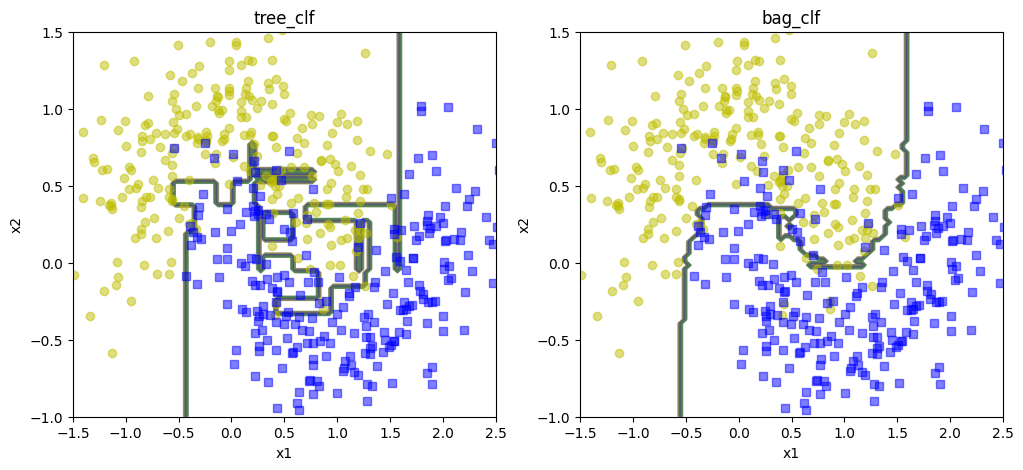

In [71]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_decision_boundary(tree_clf,X,y)
plt.title('tree_clf')
plt.subplot(122)
plot_decision_boundary(bag_clf,X,y)
plt.title('bag_clf')
plt.show()

#### OOB策略 out of bag
解决如何验证问题

In [73]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples= 100,
                            bootstrap=True,
                            n_jobs = -1,
                            random_state = 42,
                            oob_score=True
                                )

bag_clf.fit(X_train,y_train)
y_pred_bag = bag_clf.predict(X_test)
accuracy_bag = accuracy_score(y_pred_bag,y_test)

In [ ]:
bag_clf.oob_score_ # 测试集上的准确率

0.915

In [76]:
accuracy_bag

0.9

### 随机森林

In [78]:
from sklearn.datasets import load_iris
iris = load_iris()
rf_clf  = RandomForestClassifier(n_estimators=500 ,n_jobs=-1,random_state=42)
rf_clf.fit(iris['data'],iris['target'])
for name,score in zip(iris['feature_names'],rf_clf.feature_importances_):
    print(name,score)


sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [ ]:
from sklearn.datasets import fetch_openml
# 加载数据（返回展平的784维向量）
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [83]:
rf_clf  = RandomForestClassifier(n_estimators=500 ,n_jobs=-1,random_state=42)
rf_clf.fit(mnist['data'],mnist['target'])

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [84]:
rf_clf.feature_importances_.shape

(784,)

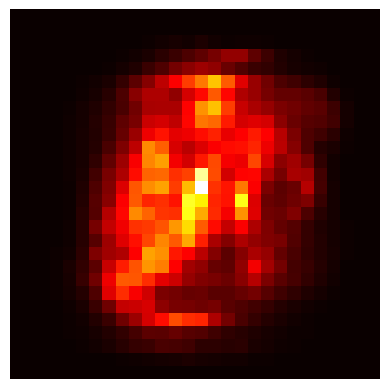

In [87]:
import matplotlib

def plot_digit(data):
    image =data.reshape(28,28)
    plt.imshow(image,cmap=matplotlib.cm.hot)
    plt.axis('off')
plot_digit(rf_clf.feature_importances_)